In [0]:
pip install tensorflow

In [0]:

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#Note: if we would need to load and save models
#from keras.models import load_model


In [6]:
# Get these stocks from yahoo using pandas data_reader
stocks= ['TSLA','AAPL']
df = pd.DataFrame()
for stock in stocks:
  tmp_df = web.DataReader(stock, data_source='yahoo', start='2012-01-03',end='2019-12-17')
  tmp_df.to_csv('/{}.csv'.format(stock))
for stock in stocks:
  tmp2 = pd.read_csv('/{}.csv'.format(stock))
  tmp2.set_index('Date',inplace=True)
  tmp2.rename(columns={'Adj Close': stock}, inplace=True)
  tmp2.drop(['High', 'Low','Open','Close','Volume'],1, inplace=True)
  if df.empty:
    df = tmp2
  else:
    df = df.join(tmp2, how='outer')
df


,TSLA,AAPL
Date,,
2012-01-03,28.080000,51.115936
2012-01-04,27.709999,51.390648
2012-01-05,27.120001,51.961189
2012-01-06,26.910000,52.504375
2012-01-09,27.250000,52.421093
...,...,...
2019-12-11,352.700012,270.769989
2019-12-12,359.679993,271.459991
2019-12-13,358.390015,275.149994


In [0]:
# Get the simple moving average for the stocks 20 days and 100 days
#df['SMA1_TSLA'] = df['TSLA'].rolling(window=20).mean()
#df['SMA2_TSLA'] = df['TSLA'].rolling(window=100).mean()
#df['SMA1_AAPL'] = df['AAPL'].rolling(window=20).mean()
#df['SMA2_AAPL'] = df['AAPL'].rolling(window=100).mean()
#df

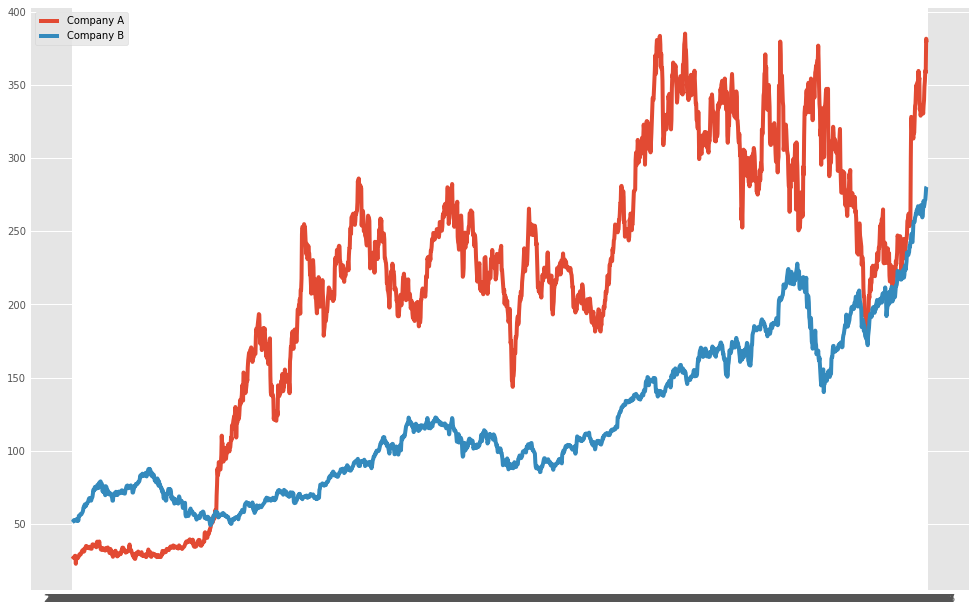

In [7]:
# visualizing the data
plt.figure(figsize = (15,10))

plt.plot(df['TSLA'], label='Company A')
plt.plot(df['AAPL'], label='Company B')

plt.legend(loc='best')
plt.show()

In [8]:
#Create a new dataframe with the 'stock' column
data = df.filter(['AAPL'])#,'SMA1_AAPL'])
#Label buy or sell if closing price is higher than Simple Moving Average

#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows (80 procent) to train the model on
training_data_len = math.ceil( len(dataset) * .8 )

print('length: {',training_data_len,'} shape: ',dataset.shape) #print
# if there are NaN values remove them (set zero)
dataset[np.isnan(dataset)] = 0
#dataset = dataset[~np.isnan(dataset)]

dataset

length: { 1603 } shape:  (2003, 1)


array([[ 51.11593628],
       [ 51.39064789],
       [ 51.96118927],
       ...,
       [275.1499939 ],
       [279.85998535],
       [280.41000366]])

In [9]:
#Scale the data between 0,1 with sklearn preprocessing tool MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00803156],
       [0.00922001],
       [0.01168828],
       ...,
       [0.97724423],
       [0.99762052],
       [1.        ]])

In [0]:

#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = [] #the dependent set

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  #if i<= 61:
   # print(x_train)
   # print(y_train)
   # print()

In [0]:
#Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

In [10]:
#Build the LSTM model
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 50
EPOCHS = 2
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(NUM_NEURONS_SecondLayer, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
#Compile the model using adam optimizer and loss function MSE
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/2





1543/1543 [==============================] - 117s 76ms/step - loss: 8.0305e-04
Epoch 2/2
1543/1543 [==============================] - 116s 75ms/step - loss: 2.9972e-04


In [0]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])



In [26]:
#Convert the data to a numpy array
x_test = np.array(x_test)
x_test

array([[0.50816406, 0.5141933 , 0.52684192, ..., 0.58323613, 0.5759986 ,
        0.58336307],
       [0.5141933 , 0.52684192, 0.54147217, ..., 0.5759986 , 0.58336307,
        0.57832646],
       [0.52684192, 0.54147217, 0.53902687, ..., 0.58336307, 0.57832646,
        0.57544832],
       ...,
       [0.73994704, 0.7260152 , 0.73028534, ..., 0.94838865, 0.95829552,
        0.9612806 ],
       [0.7260152 , 0.73028534, 0.72579954, ..., 0.95829552, 0.9612806 ,
        0.97724423],
       [0.73028534, 0.72579954, 0.74024891, ..., 0.9612806 , 0.97724423,
        0.99762052]])

In [0]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


In [0]:
#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [29]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

1.6849599456787119

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


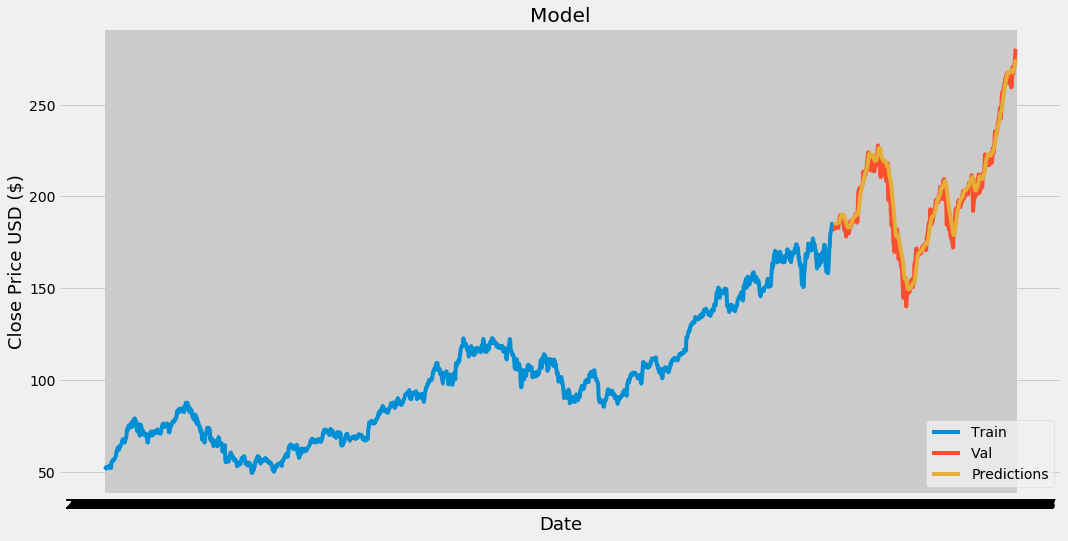

In [30]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#valid['SMA1'] = valid['Close'].rolling(window=20).mean()
#valid['SMA2'] = valid['Close'].rolling(window=100).mean()

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['AAPL'])
plt.plot(valid[['AAPL', 'Predictions']])
#plt.plot(valid['SMA1'], 'g--')
#plt.plot(valid['SMA2'], 'r--')
plt.legend( ['Train', 'Val', 'Predictions'],loc='lower right')
plt.show()

In [31]:
#Show the valid and predicted prices
valid


,AAPL,Predictions
Date,,
2018-05-17,182.939926,184.482925
2018-05-18,182.274643,184.857727
2018-05-21,183.566071,184.956131
2018-05-22,183.106216,185.069626
2018-05-23,184.280273,185.125504
...,...,...
2019-12-11,270.769989,269.626678
2019-12-12,271.459991,270.537292
2019-12-13,275.149994,271.512909


In [32]:
#Get the quote
new_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-23')
#Create a new dataframe
new_df = new_quote.filter(['Close'])
#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[282.0245]]


In [33]:
#Get the real price for next day
quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-30', end='2019-12-30')
print(quote2['Close'])

Date
2019-12-30    291.519989
Name: Close, dtype: float64
